In [1]:
import torch
import torch.nn as nn

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import cv2
import pandas as pd

import random

from sklearn.linear_model import LinearRegression

from NeuralGraph import NeuralGraph

C:\Users\Alec\AppData\Local\Temp\ipykernel_14204\1077650579.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
def split_dataset(x, y, valid_split=.2, test_split=.2):
    classes = np.unique(y)
    train_valid_split = round(len(classes)*(1-(valid_split+test_split)))
    valid_test_split = round(len(classes)*(1-test_split))

    train_classes = set(classes[:train_valid_split])
    valid_classes = set(classes[train_valid_split:valid_test_split])
    test_classes = set(classes[valid_test_split:])

    train = {i:[] for i in train_classes}
    valid = {i:[] for i in valid_classes}
    test = {i:[] for i in test_classes}

    for data, class_ in zip(x, y):
        if class_ in train_classes:
            train[class_].append(data)
        
        elif class_ in valid_classes:
            valid[class_].append(data)

        else:
            test[class_].append(data)

    for class_ in train_classes:
        train[class_] = np.stack(train[class_])

    for class_ in valid_classes:
        valid[class_] = np.stack(valid[class_])

    for class_ in test_classes:
        test[class_] = np.stack(test[class_])

    return train, valid, test

In [9]:
SIZE = 32

(x, y), (_, _) = tf.keras.datasets.cifar100.load_data()
y = y.flatten()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2, 3)

cifar_train, cifar_valid, cifar_test = split_dataset(x, y)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])


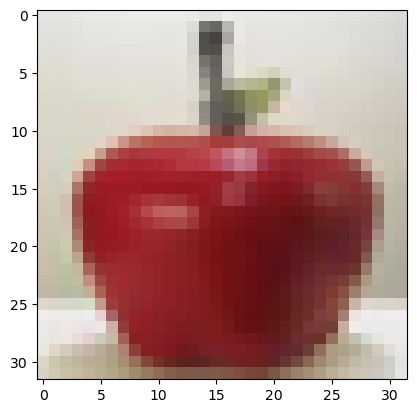

In [24]:
print(cifar_train.keys())
# print(cifar_train[0].shape)
plt.imshow(cifar_train[0][2].reshape(SIZE, SIZE, 3))# [list(train[0].keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

In [13]:
BATCH_SIZE = 16
TIME = 1
DT = .25

n_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu"


shape = [SIZE**2, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, ch_inp=3, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

log = []

2048


In [15]:
# import networkx as nx

# g = nx.DiGraph()
# g.add_nodes_from(list(range(graph.n_nodes)))
# g.add_edges_from(graph.connections)

# pos = {i:np.array([i%SIZE, i//SIZE]) for i in range(SIZE**2)}

# pos[SIZE**2] = np.array([SIZE+2, SIZE//2 - 2])
# pos[SIZE**2 + 1] = np.array([SIZE+2, SIZE//2 + 2])

# nx.draw(g, pos)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

### Memorize Task
##### Repeat input/output pairs in order they're given

In [17]:
STEPS = 3_000
EXAMPLES = 10
log = []

In [19]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, 3, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

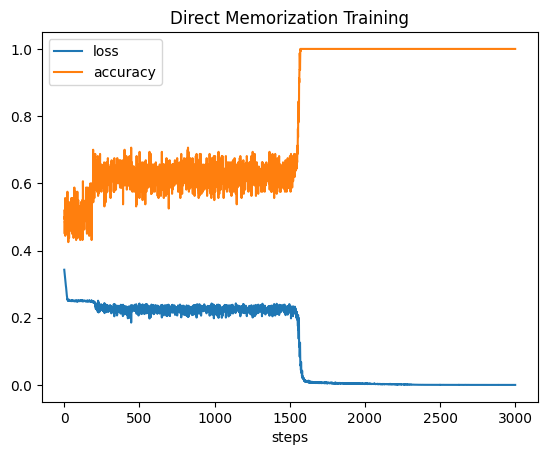

In [12]:
plt.title("Direct Memorization Training")

plt.plot([e['loss'] for e in log], label="loss")
plt.plot([e['acc'] for e in log], label="accuracy")
plt.legend()
plt.xlabel("steps")

plt.savefig("direct_memorize.png", dpi=500)
plt.show()

graph.save("models/direct_memorize.pt")

### Now train again with hidden layer

In [20]:
shape = [SIZE**2, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, ch_inp=3, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

log = []

8208


In [14]:
graph.load("models/direct_memorize.pt")

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

STEPS = 1_000
EXAMPLES = 10
log = []

In [16]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s, loss=0.000127, acc=1, overflow=7e-5]       


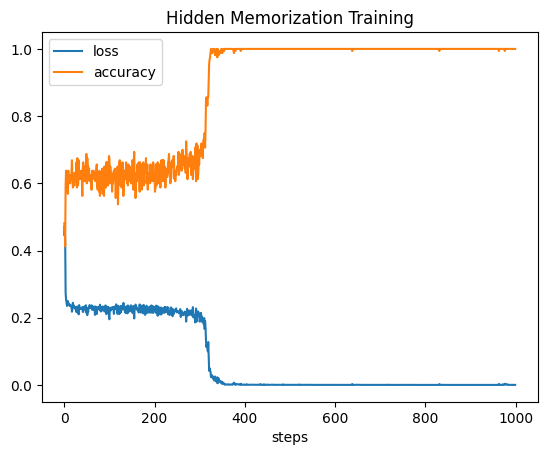

In [17]:
plt.title("Hidden Memorization Training")

plt.plot([e['loss'] for e in log], label="loss")
plt.plot([e['acc'] for e in log], label="accuracy")
plt.legend()
plt.xlabel("steps")

plt.savefig("hidden_memorize.png", dpi=500)
plt.show()

graph.save("models/direct_memorize.pt")

In [18]:
graph.save("models/memorize.pt")

### Generalization Task
##### Given input/output pairs from a specific task, given output from unseen input data from that task

In [19]:
TRAIN_EXAMPLES = 10
TEST_EXAMPLES = 10
# Reset optimizer
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

STEPS = 10_000

log = []

In [20]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

def get_batch_data(dataset=train, batch_size=BATCH_SIZE, train_examples=TRAIN_EXAMPLES, test_examples=TEST_EXAMPLES):
    if type(dataset) != list:
        dataset = [dataset]
    set_ = np.random.randint(len(dataset), size=(batch_size))

    classes = np.stack([np.random.choice(list(dataset[i].keys()), size=(n_classes), replace=False) for i in set_])
    
    # This gets completely random examples
    # y_train = np.random.randint(n_classes, size=(batch_size, train_examples))
    # y_test = np.random.randint(n_classes, size=(batch_size, TEST_EXAMPLES))

    # This gets balanced random examples
    
    y_train = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, train_examples)), axis=0), batch_size, axis=0).astype(np.int32)
    y_test = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, test_examples)), axis=0), batch_size, axis=0).astype(np.int32)

    y_train = shuffle_along_axis(y_train, axis=1)
    y_test = shuffle_along_axis(y_test, axis=1)


    x_train = []
    for batch_classes, y, i in zip(classes, y_train, set_):
        x_train.append([])
        for class_ in batch_classes[y]:
            x_train[-1].append(random.choice(dataset[i][class_]))
        x_train[-1] = np.stack(x_train[-1])
    x_train = np.stack(x_train)

    x_test = []
    for batch_classes, y, i in zip(classes, y_test, set_):
        x_test.append([])
        for class_ in batch_classes[y]:
            x_test[-1].append(random.choice(dataset[i][class_]))
        x_test[-1] = np.stack(x_test[-1])
    x_test = np.stack(x_test)
    
    return torch.Tensor(x_train).to(device), torch.Tensor(y_train).long().to(device), torch.Tensor(x_test).to(device), torch.Tensor(y_test).long().to(device), classes

In [21]:
bar = tqdm(range(1, STEPS+1))
for step in bar:

    # Train step
    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=train)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()


    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()


    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_test).float().mean()

    task_loss = criterion(pred, y_label)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    # Valid step
    with torch.no_grad():
        x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=valid)
        y_input = nn.functional.one_hot(y_train, n_classes).float()
        y_label = nn.functional.one_hot(y_test, n_classes).float()

        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        valid_acc = (pred.argmax(2) == y_test).float().mean()
        valid_loss = criterion(pred, y_label)

    # Save
    if step % 500 == 0 and step != 0:
        graph.save(f"models/generalize_{step}.pt")

    entry = {'valid_loss':valid_loss.item(), 'valid_acc':valid_acc.item(), 'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"valid_loss":np.mean([e["valid_loss"] for e in log[-10:]]), "valid_acc":np.mean([e["valid_acc"] for e in log[-10:]]), "loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

100%|██████████| 10000/10000 [1:36:45<00:00,  1.72it/s, valid_loss=0.0772, valid_acc=0.895, loss=0.0762, acc=0.896, overflow=6.13e-7]


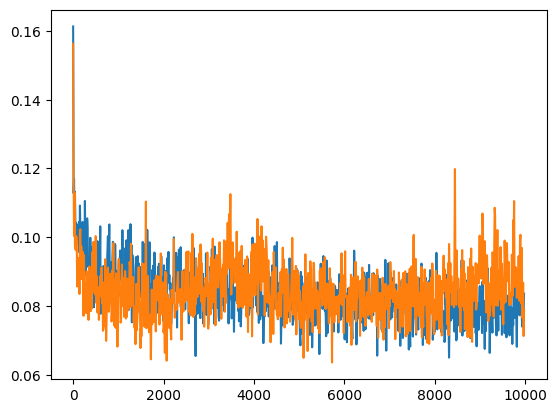

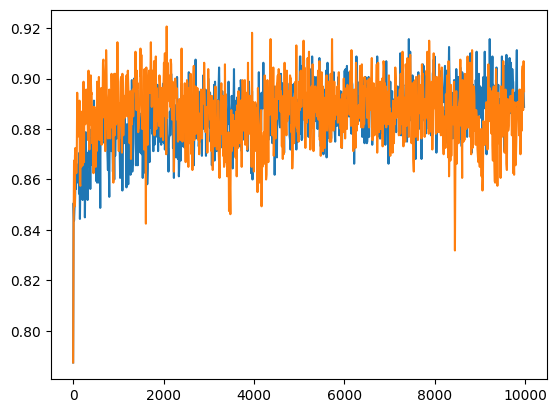

In [30]:
losses = [e["loss"] for e in log]
valid_losses = [e["valid_loss"] for e in log]

accs = [e["acc"] for e in log]
valid_accs = [e["valid_acc"] for e in log]

window = 10

plt.plot(range(0, len(losses)-window, window), [np.mean(losses[i:i+window]) for i in range(0, len(losses)-window, window)])
plt.plot(range(0, len(losses)-window, window), [np.mean(valid_losses[i:i+window]) for i in range(0, len(valid_losses)-window, window)])
plt.show()

plt.plot(range(0, len(losses)-window, window), [np.mean(accs[i:i+window]) for i in range(0, len(accs)-window, window)])
plt.plot(range(0, len(losses)-window, window), [np.mean(valid_accs[i:i+window]) for i in range(0, len(valid_accs)-window, window)])
plt.show()

In [48]:
graph.load("models/generalize_10000.pt")

### Evaluate on Train digits, Test digits, Fashion test

In [52]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(SIZE**2, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes),
            nn.Softmax(1),
        )
    
    def forward(self, x):
        return self.main(x)

def fit(model, x_train, y_train, steps=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    for e in range(steps):
        optimizer.zero_grad()
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)

        loss.backward()
        optimizer.step()

In [53]:
overall_accs = {}
overall_losses = {}

N = 2048

for data_name, dataset in {"emnist_test":emnist_test, "mnist_test":mnist_test, "fashion_test":fashion_test}.items():# ["valid"]:
    print(f"Data: {data_name}")

    accs = {"graph":[], "linreg":[], "ANN_50_steps":[], "ANN_10_steps":[], "ANN_1_steps":[]}
    losses = {"graph":[], "linreg":[], "ANN_50_steps":[], "ANN_10_steps":[], "ANN_1_steps":[]}

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=dataset, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        graph.init_vals(nodes=True, edges=True, batch_size=N)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        graph_acc = (pred.argmax(2) == y_test).float().mean()
        graph_loss = criterion(pred, y_label)

        accs["graph"].append(graph_acc.item())
        losses["graph"].append(graph_loss.item())

    # Try linear regression and an ANN on each batch
    for x_train_b, y_train_b, x_test_b, y_test_b, y_input_b, y_label_b in tqdm(zip(x_train, y_train, x_test, y_test, y_input, y_label), total=N):
        model = LinearRegression()

        model.fit(x_train_b.cpu(), y_input_b.cpu())
        pred = torch.Tensor(model.predict(x_test_b.cpu())).to(device)

        linreg_acc = (pred.argmax(1) == y_test_b).float().mean()
        linreg_loss = criterion(pred, y_label_b)

        accs["linreg"].append(linreg_acc.item())
        losses["linreg"].append(linreg_loss.item())


        # Train model for 1, 10, 50 epochs and record acc / loss
        for steps in [1, 10, 50]:
            model = Model().to(device)

            fit(model, x_train_b, y_input_b, steps=steps)
            pred = model(x_test_b)

            model_acc = (pred.argmax(1) == y_test_b).float().mean()
            model_loss = criterion(pred, y_label_b)

            accs[f"ANN_{steps}_steps"].append(model_acc.item())
            losses[f"ANN_{steps}_steps"].append(model_loss.item())

    overall_accs[data_name] = {k:np.mean(v) for k, v in accs.items()}
    overall_losses[data_name] = {k:np.mean(v) for k, v in losses.items()}

Data: emnist_test


100%|██████████| 2048/2048 [02:47<00:00, 12.20it/s]


Data: mnist_test


100%|██████████| 2048/2048 [02:47<00:00, 12.24it/s]


Data: fashion_test


100%|██████████| 2048/2048 [02:43<00:00, 12.56it/s]


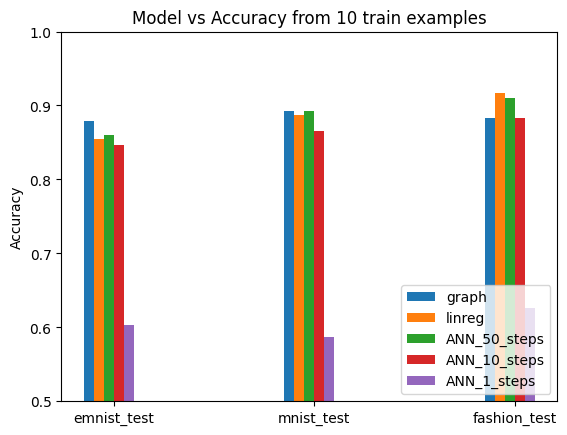

In [33]:
width=.05

plt.title("Model vs Accuracy from 10 train examples")

# plt.xticks(rotation='vertical')
plt.ylim(.5, 1)
plt.ylabel("Accuracy")

X = overall_accs.keys()
X_axis = np.arange(len(X))

plt.xticks(X_axis, X)

model_names = overall_accs[list(overall_accs.keys())[0]].keys()

for i, model_name in enumerate(model_names):
    accs = []
    for data_set in X:
        accs.append(overall_accs[data_set][model_name])
    plt.bar(X_axis + i*(width) - len(model_names)*(width/2), accs, width, label=model_name)
    

plt.legend(loc="lower right")
plt.savefig("results.png")
plt.show()

In [54]:
SIZE = 7

emnist = pd.read_csv("emnist-letters-train.csv").values

x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, _, emnist49 = split_dataset(x, y)

SIZE = 28

x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, _, emnist784 = split_dataset(x, y)

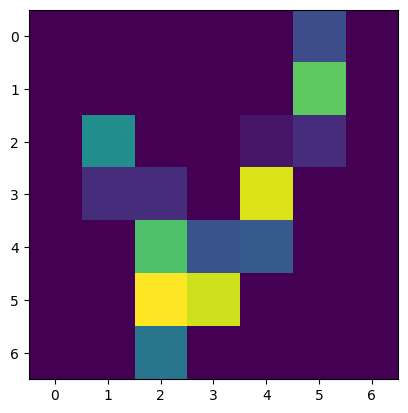

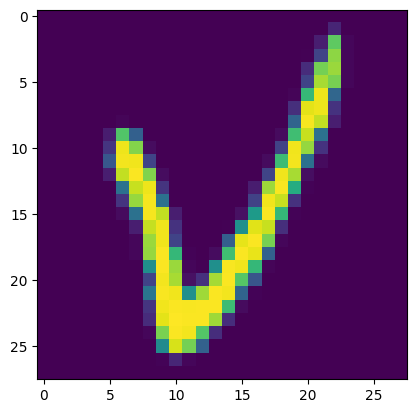

In [55]:
plt.imshow(emnist49[22][0].reshape(7, 7))
plt.show()
plt.imshow(emnist784[22][0].reshape(28, 28))
plt.show()

In [56]:
shape = [49, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph49 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph49.load("models/generalize_10000.pt")

shape = [784, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph784 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph784.load("models/generalize_10000.pt")

408
6288


In [57]:
N = 2048

accs = {}
losses = {}

for data_name, dataset, g in zip(["emnist 7x7", "emnist 14x14", "emnist 28x28"], [emnist49, emnist_test, emnist784], [graph49, graph, graph784]):
    print(f"Data: {data_name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=dataset, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[data_name] = acc.item()
        losses[data_name] = loss.item()

Data: emnist 7x7
Data: emnist 14x14
Data: emnist 28x28


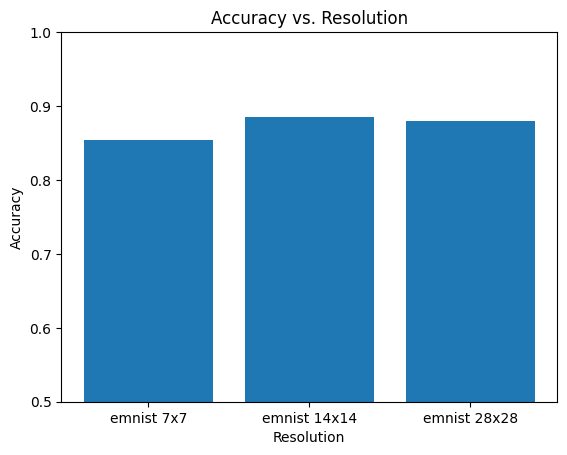

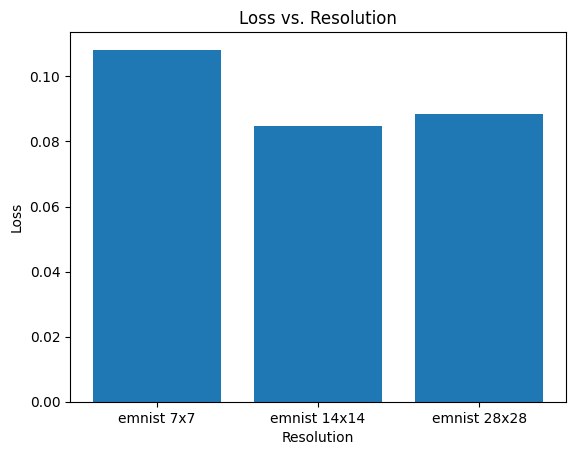

In [60]:
plt.title("Accuracy vs. Resolution")
plt.xlabel("Resolution")
plt.ylabel("Accuracy")
plt.bar(accs.keys(), accs.values())
plt.ylim(.5, 1)
plt.savefig("resolutions.png")
plt.show()


plt.title("Loss vs. Resolution")
plt.xlabel("Resolution")
plt.ylabel("Loss")
plt.bar(losses.keys(), losses.values())
plt.show()

In [61]:
shape = [14**2, 4, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_h4 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_h4.load("models/generalize_10000.pt")

shape = [14**2, 16, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_h16 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_h16.load("models/generalize_10000.pt")

792
3168


In [63]:
accs = {}
losses = {}

for name, g in zip(["4 hidden", "8 hidden", "16 hidden"], [graph_h4, graph, graph_h16]):
    print(f"Data: {name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=emnist_test, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[name] = acc.item()
        losses[name] = loss.item()

Data: 4 hidden
Data: 8 hidden
Data: 16 hidden


In [64]:
print(accs)

{'4 hidden': 0.884960949420929, '8 hidden': 0.887011706829071, '16 hidden': 0.8814453482627869}


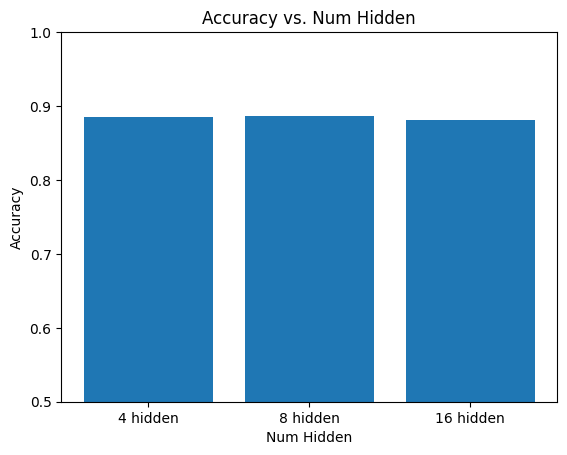

In [66]:
plt.title("Accuracy vs. Num Hidden")
plt.xlabel("Num Hidden")
plt.ylabel("Accuracy")
plt.bar(accs.keys(), accs.values())
plt.ylim(.5, 1)
plt.savefig("hidden.png")
plt.show()